# Simple Self Contained Model of the Funcspec Project

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import DataLoader
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
col = ['xkcd:cloudy blue', 'xkcd:gray', 'xkcd:orange', 'xkcd:dark seafoam', 'xkcd:purple']


## Data

### Datasets

In [5]:
from community.data.datasets import get_datasets_symbols
from community.common.utils import plot_grid, create_gifs

In [6]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
n_classes = 4
task = 'parity'

In [266]:
data_config = {'data_size' : (30000, 5000),
                                'nb_steps' : 50,
                                'n_symbols' : n_classes - 1,
                                'symbol_type' : '0',
                                'input_size' : 30,
                                'static' : True                      
    }

if data_config['static'] : 
    data_config['nb_steps'] = 10
    data_config['data_size']  = [d*4 for d in data_config['data_size']]

loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=False)


Generating Data: 100%|██████████| 20000/20000 [00:00<00:00, 65854.16it/s]


## Tasks

In [215]:
def get_task_target(target, task) : 
    tasks = task.split('_')
    try :
        task = int(tasks[-1])
        target = target[:, task]
    except ValueError : 
        'continue'
    if 'parity' in tasks :
        target = parity_task(target)
    elif 'count' in tasks : 
        if 'max' in tasks : 
            target = symbol_count(target)
        elif 'equal' in tasks : 
            target = symbol_count(target) != 0
    elif 'nonzero' in tasks : 
        target = target > 0
    elif 'none' in tasks : 
        target = target
    else : 
        raise NotImplementedError

    return target.type(torch.LongTensor).to(target.device)

def parity_task(target) : 

    parity = 1 - target.sum(-1)%2
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    return parity_target

def new_parity_task(target) : 
    parity = 1 - target.sum(-1)%2
    equal = (target[:, 0].eq(target[:, 1]))
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    parity_target = torch.where(equal, torch.full_like(parity_target, n_classes), parity_target)

    return parity_target

def process_data(data, flatten=True, symbols=True, device=device) : 
    if symbols : data =  data.permute(1, 2, 0, 3, 4)
    if flatten : data = data.flatten(start_dim=-2) 
    else : 
        data = data.unsqueeze(3)
    
    return data.float().to(device)
    
def get_data(task=None, flatten=True, device=device) : 
    data, target = next(iter(loaders[1]))
    print(data.shape)
    data = process_data(data, flatten=flatten)
    if task : target = get_task_target(target, task)

    return data, target.float().to(device)


def symbol_count(target) : 
    new_target = torch.where(target.argmax(-1).bool(), target[:, 1], target[:, 0])
    new_target[target[:, 0] == target[:, 1]] = 0
    return new_target


(tensor([False,  True]), tensor([10589,  9379]))


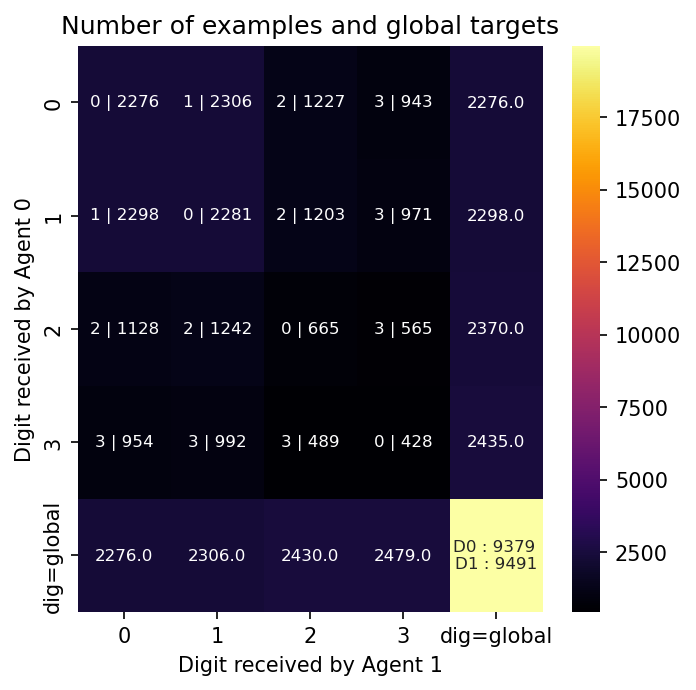

In [267]:
task = 'max_count'
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])

if True : 
    
    all_targets = get_all_targets()
    uniques, unique_counts = all_targets.unique(dim=0, return_counts=True)
    task_t = get_task_target(all_targets, task)
    task_t.unique(dim=0, return_counts=True), (all_targets[:, 0] == task_t).unique(dim=0, return_counts=True), (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)
    digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
    digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
    counts = np.zeros((n_classes+1, n_classes+1))
    targets = np.zeros((n_classes+1, n_classes+1), dtype=object)

    for d1 in range(n_classes) : 
        counts[d1, -1] = ((all_targets[:, 0] == task_t)[all_targets[:, 0] == d1]).sum() #unique_counts[(uniques == d1)[:, 0]].sum()
        targets[d1, -1] = str( counts[d1, -1])
        for d2 in range(n_classes) : 
            if digits_in(d1, d2) : 
                counts[d1, d2] = unique_counts[digits_idx(d1, d2)]
                targets[d1, d2] = f'{get_task_target(uniques, task)[digits_idx(d1, d2)].cpu().data.item()} | {unique_counts[digits_idx(d1, d2)]}'
            else : 
                counts[d1, d2] = -0.1
                targets[d1, d2] = 'X'
            counts[-1, d2] = ((all_targets[:, 1] == task_t)[all_targets[:, 1] == d2]).sum() #unique_counts[(uniques == d2)[:, 1]].sum()
            targets[-1, d2] = str( counts[-1, d2])

    counts[-1, -1] = unique_counts.sum().cpu().data.item()
    try : 
        d0_count =  (all_targets[:, 0] == task_t).unique(dim=0, return_counts=True)[1][1]
        print((all_targets[:, 0] == task_t).unique(dim=0, return_counts=True))
    except IndexError : 
        d0_count = 0
    try : 
        d1_count =  (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)[1][1]
    except IndexError : 
        d1_count = 0

    targets[-1, -1] = str(f'D0 : {d0_count} \n'
                    f'D1 : {d1_count}')
                
    plt.figure(figsize=(5, 5), dpi=150)
    ax = sns.heatmap(counts, cmap="inferno", annot=targets, annot_kws={'fontsize': 8}, fmt='s')
    ax.set_title('Number of examples and global targets')

    ax.set_xlabel('Digit received by Agent 1')
    ax.set_ylabel('Digit received by Agent 0')
    ax.set_xticklabels([str(i) for i in range(n_classes)] + ['dig=global'])
    ax.set_yticklabels([str(i) for i in range(n_classes)] + ['dig=global'])

    plt.show()

Stats

In [249]:
#loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda)
all_targets = get_all_targets()
task_t = get_task_target(all_targets, task)
all_targets[:, 1].unique(return_counts=True), task_t.unique(return_counts=True)

((tensor([0, 1, 2, 3]), tensor([5028, 4999, 4942, 4999])),
 (tensor([0, 1, 2, 3]), tensor([5007, 2471, 5028, 7462])))

In [244]:
datasets[0].regenerate = False
data, target = get_data(flatten=False)
print(data.shape)
create_gifs(data[..., 0, :, :], target, 'symbols', data_config['input_size'], 'count_max')

torch.Size([256, 10, 2, 30, 30])
torch.Size([10, 2, 256, 1, 30, 30])


## Models

In [217]:
class SmoothStep(torch.autograd.Function):
    '''
    Modified from: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    '''

    @staticmethod
    def forward(aux, x, thr=0):
        aux.save_for_backward(x)
        return (x >=thr).type(x.dtype)

    def backward(aux, grad_output):
        # grad_input = grad_output.clone()
        input, = aux.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= -.5] = 0
        grad_input[input > .5] = 0
        return grad_input
    
smooth_step = SmoothStep().apply
sigmoid = nn.Sigmoid()

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input, thr=0):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = -torch.ones_like(input)
        out[input > thr] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
super_spike  = SurrGradSpike.apply

In [218]:

def get_padding(S, K, W) : 
    return int(((S-1)*W-S+K)/2)

def init_weights(net, scale) : 
    for n, p in net.named_parameters() : 
        torch.nn.init.xavier_normal_(p)
        p.data *= scale

class Agent(nn.Module) : 

    def __init__(self, dims, use_conv=False, use_bottleneck=False, dropout=0., w_scale=1.) : 
        super().__init__()
        self.dims = dims
        if use_conv : 
            #K, S, W = 3, 1, data_config['input_size'] 
            #P = get_padding(S, K, W)
            convs = []
            channels = [1, 2]
            kernels = [3, 3]
            pools = [2, 2]
            feature_height, feature_width = [data_config['input_size']] * 2
            for i, (K, P, n_in, n_out) in enumerate(zip(kernels, pools, channels[:-1], channels[1:])) :
                
                convs.append(nn.Conv2d(n_in, n_out, K, 1, padding='same'))
                convs.append(nn.MaxPool2d(P))
                convs.append(nn.ReLU())
                if dropout > 0. : 
                    convs.append(nn.Dropout(dropout))

            convs.append(nn.Flatten())
            self.conv = nn.Sequential(*convs)
            
            #self.conv = nn.Sequential(nn.Conv2d(1, 8, K, S, P), nn.Flatten())

            dummy_data = torch.zeros([1] + [channels[0]]+ [data_config['input_size']] * 2) 
            dummy_out = self.conv(dummy_data)
            print(dummy_out.shape)
            self.dims[0] = dummy_out.shape[-1]
        else : 
            self.conv = None

        self.use_bottleneck = use_bottleneck

        if data_config['static'] : 
            self.cell = nn.RNN(dims[0], dims[1], 1, bias=False, batch_first=False)
        else : 
            self.cell = nn.GRU(dims[0], dims[1], 1, bias=False, batch_first=False)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

        if use_bottleneck :  
            n_bot = 5
            self.bottleneck = nn.Sequential(nn.Linear(dims[1], n_bot, bias=False), nn.ReLU()) 
            self.bottleneck.out_features = n_bot
            self.readout = nn.Sequential(nn.Linear(n_bot, dims[-1], bias=False), nn.Softmax())
        else :
            self.readout = nn.Sequential(nn.Linear(dims[1], dims[-1], bias=False), nn.Softmax())

        init_weights(self, w_scale)

        #self.readout = nn.Linear(dims[1], dims[2], bias=False)

    def forward(self, input, state=None, connections=0) : 

        if self.conv : 
            input = self.conv(input)

        if len(input.shape ) < 3 : 
            input = input.unsqueeze(0)

        if state is None : 
            out, h = self.cell(input)
        else : 
            h = state + connections
            out, h = self.cell(input, h)

        if self.dropout : 
            out = self.dropout(out)

        if self.use_bottleneck : 
            out = self.bottleneck(out[0]).unsqueeze(0)

        out = self.readout(out[0])

        return out, h

class Connection(nn.Linear) : 

    def __init__(self, dims, p, binarize=False, w_scale=1.) : 

        super().__init__(dims[0], dims[1], bias=False)

        init_weights(self, w_scale)

        self.sparsity = p
        n_in, n_out = dims
        self.nb_non_zero = int(p*n_in*n_out)
        w_mask = np.zeros((n_in, n_out), dtype=bool)
        ind_in, ind_out = np.unravel_index(np.random.choice(np.arange(n_in*n_out), self.nb_non_zero, replace=False), (n_in, n_out))
        w_mask[ind_in, ind_out] = True
        w_mask = torch.tensor(w_mask)
        self.register_buffer('w_mask', w_mask)
        self.binarize = binarize
        
        assert w_mask.sum() == self.nb_non_zero, f'Number of nonzero connection is {w_mask.sum()}, expected {self.nb_non_zero}'

    def forward(self, input) : 
        out = F.linear(input, self.weight*self.w_mask)
        assert ((out != 0).float().sum(-1).max() <= self.nb_non_zero), f'{(out != 0).float().sum(-1).max()} non zero connections, expected {self.nb_non_zero} !'
        if self.binarize  : 
            out = super_spike(out)
        return out

class DroupoutMasked(nn.Dropout) : 
    #Dropout mask that can't put nonzero connections at zero
    def __init__(self, conn_mask, p: float = 0.5, inplace: bool = False) -> None:
        super().__init__(p, inplace)
        
        #True where connections are nonzero else False
        self.register_buffer('conn_mask', conn_mask)

    def forward(self, x) : 
        x_temp = super().forward(x)

        conn_mask = self.conn_mask.expand_as(x_temp)
                
        #Final dropout mask, True where not dropped or connections are nonzero
        mask = (x_temp != 0) | (conn_mask)

        return x * mask

class Ensemble(nn.Module) : 
    def __init__(self, dims, p, use_conv=False, binary_con=False, use_bottleneck=False, dropout=0., w_scale=1.) : 

        super().__init__()
        self.n_in, self.n_hid, self.n_out = dims
        self.connections = nn.ModuleList([Connection([dims[1]]*2, p, binary_con, w_scale) for _ in range(2)])
        
        self.conn_masks = [c.w_mask for c in self.connections]
        
        self.nonzero_received = [torch.where(c)[0] for c in self.conn_masks][::-1]
        self.nonzero_sent = [torch.where(c)[1] for c in self.conn_masks]

        self.agents = nn.ModuleList([Agent(dims, use_conv, use_bottleneck, dropout, w_scale) for i in range(2)])[::-1]
        self.is_community = True

    def forward(self, input): 

        states, outputs, conns = [[None] for _ in range(2)], [[] for _ in range(2)], [[] for _ in range(2)]
        
        for t, t_input in enumerate(input) :
            for ag, agent in enumerate(self.agents) : 
                
                ag_input = t_input[ag]
                
                if t>0 : 
                    input_connect = self.connections[1-ag](states[1-ag][-1])
                else : 
                    input_connect = 0                
                
                out, h = agent(ag_input, states[ag][-1], input_connect)
    
                states[ag].append(h)
                outputs[ag].append(out)
                conns[ag].append(input_connect)

        outputs = torch.stack([torch.stack(o) for o in outputs], 1)
        states = torch.cat([torch.stack(s[1:]) for s in states], 1)
        conns = torch.cat([torch.stack(c[1:]) for c in conns], 1)
        
        #print((outputs[-1][1] == outputs[-1][1]).all())

        return outputs, states, conns
     

## Decisions


In [121]:
def get_decision(outputs, decision_params, target=None) : 
    temporal_decision, agent_decision = decision_params

    if temporal_decision == 'last' : 
        outputs = outputs[-1]
    elif temporal_decision == 'sum' : 
        outputs = outputs.sum(0)
    else : 
        raise NotImplementedError
    try : 
        deciding_ags = int(agent_decision)
        outputs = outputs[deciding_ags]
        deciding_ags = torch.ones(outputs.shape[0])*deciding_ags
        return outputs, deciding_ags

    except ValueError : 

        if agent_decision == 'loss' :
            assert target is not None, 'Provide target for min loss decision'
            loss, min_idxs = torch.stack([F.cross_entropy(out, target, reduction='none') for out in outputs]).min(0)
            min_idxs = min_idxs.unsqueeze(-1).expand_as(outputs[0])
            outputs = torch.where(~min_idxs.bool(), outputs[0], outputs[1])
            deciding_ags = min_idxs[..., 0]
            return outputs, deciding_ags

        elif agent_decision == 'max' : 
            device = outputs.device
            n_agents = outputs.shape[0]
            max_out = lambda i : torch.max(outputs[i,...], axis=-1)
            _, deciding_ags = torch.max(torch.stack([max_out(i)[0] for i in range(n_agents)]), axis=0)
            mask_1 = deciding_ags.unsqueeze(0).unsqueeze(-1).expand_as(outputs)
            mask_2 = torch.einsum('b, bcx -> bcx', torch.arange(n_agents).to(device), torch.ones_like(outputs))
            mask = (mask_1 == mask_2)

            return (outputs*mask).sum(0), deciding_ags
        elif agent_decision == 'both' : 
            return outputs, None

        else : 
            raise NotImplementedError

def check_grad(model, task_id = '0') : 
    for n, p in model.named_parameters() : 
        if 'k_params' in n or 'all_scores' in n : 
            if task_id in n : 
                return check_ind_grad(n, p)
        else : 
            check_ind_grad(n, p)

def check_ind_grad(n, p) : 
    if p.grad is not None : 
        if (p.grad == 0).all() : 
            ''
            print(f'{n}, Zero Grad')
        #else : print(f'{n} : {p.grad}')
    elif p.requires_grad : 
        ''
        print(f'{n}, None Grad')

## Init

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 200], [-1, 1, 200]]               0
            Linear-2                    [-1, 4]             800
           Softmax-3                    [-1, 4]               0
Total params: 800
Trainable params: 800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


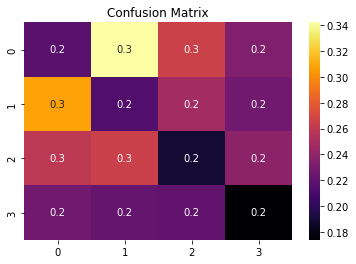

In [268]:
task = 'count_max'

dims = [data_config['input_size']**2, 200, n_classes if not (task=='equal_count' or task=='nonzero') else 2]
sparsity = 0.9#100 * 1/dims[1]**2

use_conv = False
binary_connections = True
use_bottleneck = False

community = Ensemble(dims, sparsity, use_conv, binary_connections, use_bottleneck, dropout=0., w_scale=0.1).to(device)

optimizer = torch.optim.Adam(community.parameters(), lr=1e-6)

gamma = 1 #** (1/len(loaders[0]))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma, verbose=False)
#if use_conv :
    #summary(community.agents[0].conv, (1, data_config['input_size'], data_config['input_size']) if use_conv else (1, data_config['input_size']**2))

summary(community.agents[0], (1, data_config['input_size'], data_config['input_size']) if use_conv else (1, data_config['input_size']**2))

plot_confusion_mat(community)

In [237]:
data, target = get_data(flatten=not use_conv, device=device)
#print(data.shape)
out, states, conns = community(data)
if binary_connections : print(conns[-1].unique(return_counts=True))
#symbol_count(target).unique(return_counts=True), (symbol_count(target) == target[:, 0]).unique(return_counts=True)

torch.Size([256, 10, 2, 30, 30])
(tensor([-1.,  1.], device='cuda:0', grad_fn=<Unique2Backward0>), tensor([50854, 51546], device='cuda:0'))


In [17]:
community.load_state_dict(torch.load(f'saves/network_{n_classes}{"_non"*(1 - data_config["static"])}_static_p={sparsity}'))

RuntimeError: Error(s) in loading state_dict for Ensemble:
	size mismatch for agents.0.cell.weight_ih_l0: copying a param with shape torch.Size([300, 900]) from checkpoint, the shape in current model is torch.Size([100, 900]).
	size mismatch for agents.0.cell.weight_hh_l0: copying a param with shape torch.Size([300, 100]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for agents.1.cell.weight_ih_l0: copying a param with shape torch.Size([300, 900]) from checkpoint, the shape in current model is torch.Size([100, 900]).
	size mismatch for agents.1.cell.weight_hh_l0: copying a param with shape torch.Size([300, 100]) from checkpoint, the shape in current model is torch.Size([100, 100]).

In [ ]:
#Stop exec before training
raise StopIteration

StopIteration: 

## Training

In [269]:
n_epochs = 100

decision_params = ('last', 'max') # Change to '0', '1' or 'loss'
#task = 'count'

pbar = tqdm_n(range(n_epochs))
descs = np.full((2), '', dtype=object)

check_gradients = False
train, test = True, True
early_stop = True
test_cheat = False

best_acc = 0
acc_hist, loss_hist = [[] for _ in range(2)], [[] for _ in range(2)]

def get_loss(output, t_target, task) : 
    try : 
        loss = F.cross_entropy(output, t_target, reduction='none')
        #if task == 'equal_count' : 
        #loss[t_target == 0] *= 2
    except ValueError : 
        loss = torch.stack([F.cross_entropy(o, t, reduction='none') for o, t in zip(output, t_target.T)])
        #if task == 'equal_count' : 
            #loss[t_target.T == 0] *= 2
    return loss

for epoch in pbar : 
    train_loader, test_loader = loaders

    if train : 
            
        # Training
        losses, accs = [], []
        for batch_idx, (data, target) in enumerate(train_loader) : 
            
            data = process_data(data, not use_conv, True, device)
            t_target, target = get_task_target(target, task).to(device), target.to(device)
            
            if test_cheat : 
                data[:, 0] = data[:, 1]

            optimizer.zero_grad()

            outputs, states, conns = community(data)
            #print((outputs[-1][0] == outputs[-1][1]).all())

            output, deciding_ags = get_decision(outputs, decision_params)

            loss = get_loss(output, t_target, task)
            t_masks = [(target == t ).all(1) for t in target.unique(dim=0)]
            #t_masks = [(target == t).any(1)]
            #masks = [(t_target == 0)*t_masks[0], (t_target == 3)*t_masks[0]]
            factors = torch.ones(len(t_masks))
            factors[0] *= 1

            loss = torch.stack([loss[m].mean()*f for m, f in zip(t_masks, factors)]).mean()
            loss.backward()
            losses.append(loss.cpu().data.item())

            if check_gradients : 
                zero_grads = np.array([((p.grad == 0).all()).cpu().data.item() for p in community.parameters() if p.grad is not None])
                none_grads = np.array([p.grad is None for p in community.parameters()])
                zero_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[~none_grads][zero_grads]
                none_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[none_grads]

                print(f'Zero params : {zero_params}')
                print(f'None Params : {none_params}')
                
            optimizer.step()#, scheduler.step()

            pred = output.argmax(dim=-1, keepdim=True)
            correct = pred.eq(t_target.view_as(pred))
            acc = (correct.sum() / t_target.numel()).cpu().data.numpy()
        
            #acc = [(correct[m].sum()/m.sum()).cpu().data.numpy() for m in masks]

            accs.append(acc)

            descs[0] = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Accuracy: {}%'.format(
                            epoch, batch_idx  * batch_size, len(train_loader.dataset),
                            100. * batch_idx / len(train_loader), loss.item(),
                            ([np.round(100*a) for a in acc]) if type(acc) is list else np.round(100*acc))
                            )

            pbar.set_description((descs.sum()))
        
        loss_hist[0].append(np.mean(losses))
        acc_hist[0].append(np.mean(accs))

    if test : 
        losses, accs = [], []
        for batch_idx, (data, target) in enumerate(test_loader) : 
            
            data = process_data(data, not use_conv, True, device)
            if test_cheat : 
                data[:, 0] = data[:, 1]
            target = get_task_target(target, task).to(device)

            outputs, states, conns = community(data)
            #print((outputs[-1][0] == outputs[-1][1]).all())
            output, deciding_ags = get_decision(outputs, decision_params, target)

            loss = get_loss(output, target, task)
            loss = loss.mean()
            losses.append(loss.cpu().data.item())

            pred = output.argmax(dim=-1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().cpu().data.item()
            accs.append(correct / target.numel())

        acc = np.mean(accs)

        loss_hist[1].append(np.mean(losses))
        acc_hist[1].append(np.mean(accs))
        
        descs[1] = str('| Test : Loss: {:.3f}, Accuracy: {}%'.format(
                        loss.item(),
                        (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                        )

        pbar.set_description((descs.sum()))

    scheduler.step()
    
    if acc > best_acc : 
        best_model = deepcopy(community)
        best_acc = acc
        
    if acc > 0.95 and early_stop: 
            break
            #continue
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [225]:
correct[masks[0]]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

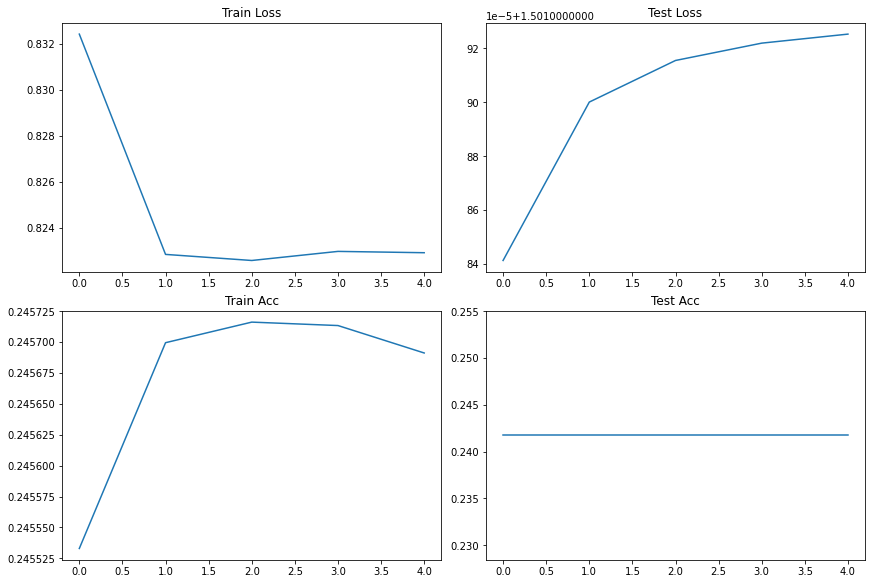

In [181]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8)) 
for metric, m_axs, m_name in zip([loss_hist, acc_hist], axs, ['Loss', 'Acc']) : 
    for trial, ax, t_name in zip([0, 1], m_axs, ['Train', 'Test']) : 
        ax.plot(metric[trial])
        ax.set_title(f'{t_name} {m_name}')

In [211]:
[m.sum() for m in masks]

[tensor(5, device='cuda:0'), tensor(77, device='cuda:0')]

In [ ]:
torch.save(best_model.state_dict(), f'saves/network_{task}_{n_classes}{"_non"*(1 - data_config["static"])}_static_p={sparsity}') 

### Confusion Matrix

/home/gb21/.conda/envs/community/lib/python3.10/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


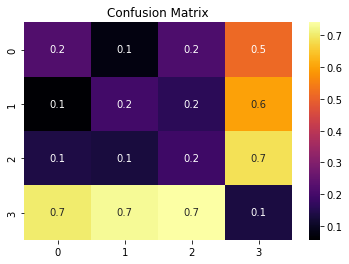

In [265]:
def plot_confusion_mat(model) : 

    accs = []
    targets, t_targets = [], []
    for batch_idx, (data, target) in enumerate(test_loader) : 
        
        data = process_data(data, not use_conv, True, device)
        t_target = get_task_target(target, task).to(device)

        outputs, states, conns = model(data)
        #print((outputs[-1][0] == outputs[-1][1]).all())
        output, deciding_ags = get_decision(outputs, decision_params, target)

        loss = F.cross_entropy(output, t_target)

        pred = output.argmax(dim=-1, keepdim=True)
        correct = pred.eq(t_target.view_as(pred)).cpu().data
        targets.append(target.cpu())
        t_targets.append(t_target.cpu())
        accs.append(correct)

    accs, targets = torch.cat(accs), torch.cat(targets)
    t_masks = [(targets == t ).all(1) for t in targets.unique(dim=0)]
    acc_per_target = [accs[m].float().mean() for m in t_masks]
    acc_per_target = np.array([[acc_per_target[t1*n_classes + t2].cpu().data.item() for t1 in range(n_classes)] for t2 in range(n_classes)])

    ax = sns.heatmap(acc_per_target, cmap="inferno", annot=acc_per_target.round(1).astype(str), annot_kws={'fontsize': 10}, fmt='s')
    ax.set_title('Confusion Matrix')   
    plt.show()

plot_confusion_mat(best_model)

In [106]:
acc_per_target.mean(), accs.float().mean()

(0.8267422057688236, tensor(0.8845))

## Analysis

### Connections

torch.Size([256, 5, 2, 30, 30])


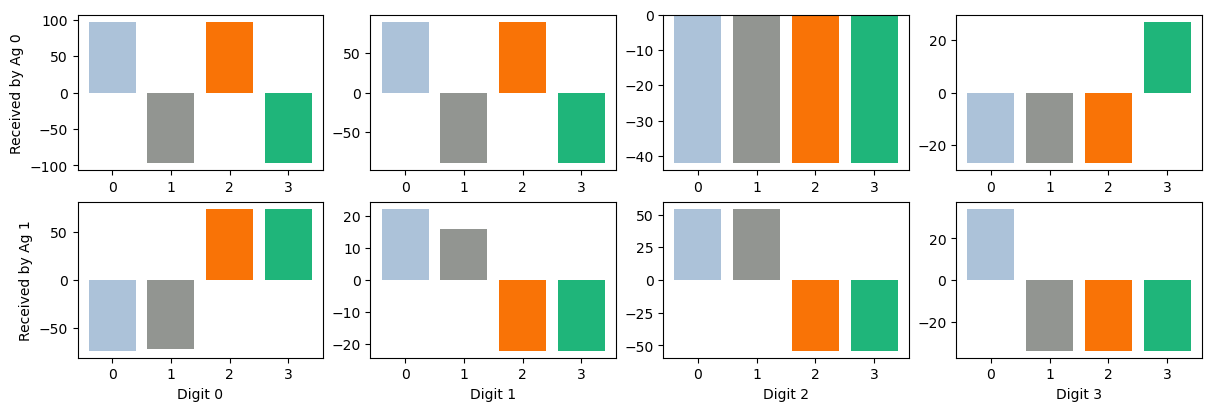

In [78]:
community.to(device)
nonzero_idxs = community.nonzero_received
n_conns = len(nonzero_idxs[0])

#for data, target in loaders[1] : 
data, target = get_data(flatten = not use_conv)
    
#data, target = process_data(data, True, True, device), target.to(device)
out, states, conns = best_model(data.to(device))

#conns[-1][0].count_nonzero(dim=0)
#torch.stack([conns[-1][i].count_nonzero(dim=0).max() for i in range(2)])
#sums.append(torch.tensor([[conns[-1][i][target[:, i] == t].sum() for t in range(4)] for i in range(2)]))

nrows, ncols = 2, n_classes
"""
ncols = int(np.sqrt(n_conns))
nrows = n_conns // ncols
if ncols * nrows < n_conns : 
    ncols += 1
print(nrows, ncols)
"""

if data_config['static'] :
    sums = [[conns[-1][i][target[:, 1-i] == t][:, nonzero_idxs[i]].sum(0) for t in range(n_classes)] for i in range(2)]
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(n_classes*3, 4), constrained_layout=True, dpi=100)

    for ag, ag_axs in enumerate(axs) : 
        for dig, ax in enumerate(ag_axs) : 
            sum = sums[ag][dig].cpu().data.numpy()
            bars = ax.bar(np.arange(len(sum)), sum, color=col)
            #ax.set_xticks(np.arange(len(sum)))
            #ax.bar_label(bars)
            #sns.heatmap(sum, cmap="inferno", annot=sum.round(1).astype(str), annot_kws={'fontsize': 16}, fmt='s', ax=ax)
            
            if ag == 1 : ax.set_xlabel(f'Digit {dig}')
            if dig == 0 : ax.set_ylabel(f'Received by Ag {ag}')
            

else : 
    lines = ['-', '--']
    fig = plt.figure(constrained_layout=True, figsize=(12, 4), dpi=130)
    fig.suptitle('Connections Through Time')
    subfigs = fig.subfigures(nrows=2, ncols=1)

    sums = torch.stack([torch.stack([conns[:, i, target[:, 1-i] == t][..., nonzero_idxs[1-i]].sum(1) for t in range(n_classes)]) for i in range(2)])
    for ag, subfig in enumerate(subfigs) : 
        subfig.suptitle(f'Agent {ag}')

        axs = subfig.subplots(nrows=nrows, ncols=ncols)
        if n_conns == 1 : 
            axs = [axs]
        for i, ax in enumerate(axs.flatten()) : 
            sum = sums.cpu().data.numpy()[ag, ..., i]
            for t, s in enumerate(sum) : 
                ax.plot(range(len(s)), s, label=f'Digit {t}', linestyle=lines[t%2])

            ax.legend()
            ax.set_title(f'Connection {i}')

### Decisions

/tmp/ipykernel_61206/2224769916.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = target.eq(torch.tensor(t)).all(axis=1)


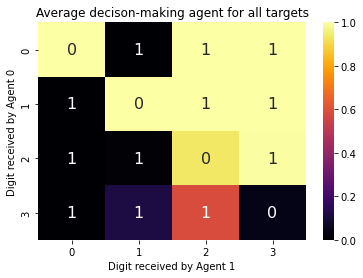

In [ ]:
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])

all_targets = get_all_targets()

uniques = all_targets.unique(dim=0).cpu()
decision_means = torch.zeros(len(uniques))

community.to('cpu')

for b_idx, (data, target) in enumerate(loaders[1]) : 
    
    data, target = process_data(data, True, True, 'cpu'), target.to('cpu')
    t_target = get_task_target(target, task).cpu()
    output, *_ = community(data)
    output, decision_ags = get_decision(output, decision_params, target=t_target)

    for i, t in enumerate(uniques) :             
        mask = target.eq(torch.tensor(t)).all(axis=1)
        if mask.sum() != 0 : 
            decision_means[i] += decision_ags[mask].float().cpu().sum()/mask.sum()

decision_means /= b_idx +1

digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
decisions = np.zeros((n_classes, n_classes))
targets = np.zeros((n_classes, n_classes), dtype=object)

for d1 in range(n_classes) : 
    for d2 in range(n_classes) : 
        if digits_in(d1, d2) : 
            decisions[d1, d2] = decision_means[digits_idx(d1, d2)]
            targets[d1, d2] = str(get_task_target(uniques, task)[digits_idx(d1, d2)].cpu().data.item())
        else : 
            decisions[d1, d2] = -0.1
            targets[d1, d2] = 'X'
            
ax = sns.heatmap(decisions, cmap="inferno", annot=targets, annot_kws={'fontsize': 16}, fmt='s')
ax.set_title('Average decison-making agent for all targets')

ax.set_xlabel('Digit received by Agent 1')
ax.set_ylabel('Digit received by Agent 0')

plt.show()

community.to(device);                                                                                     

### Conv Filters

In [ ]:
if use_conv : 

    convs = [[c for c in ag.conv if type(c) is torch.nn.Conv2d] for ag in community.agents]
    symbols = datasets[0].symbols

    fig = plt.figure(constrained_layout=True, figsize=((convs[0][0].out_channels + 1) *2, 5))
    #fig.suptitle('Conv Weights')

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=len(convs), ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'Agent {row}')

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=len(convs[row]), ncols=convs[row][0].out_channels + 1)
        
        for col, ax in enumerate(axs[:-1]):
            im = ax.imshow((convs[row][0].weight.data.cpu().numpy()[col, 0]))
            ax.set_title(f'Conv weight {col}')

        ax = axs[-1]
        im = ax.imshow(symbols[row])
        ax.set_title('Sym to be detected')
      
        cbar = subfig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)


## Funcspec Metrics

### New Correlation 

In [72]:
def get_input_variations(dataset, index) : 

    original_data, original_label = (d.clone() for d in dataset[index])

    scenarios = ['Original', 'Same_Count', '0_only', '1_Only', 'Symbol_Inv']
    labels = [[original_label], [original_label], [torch.tensor([n_classes-1, 0])], [torch.tensor([0, n_classes-1])], [original_label]]
    labels = [l * 10 for l in labels]

    data_var = {s : [] for s in scenarios}
    for l in labels[0] : 
        data_var['Original'].append(original_data)

    dataset.regenerate = True
    for i, (lab, s) in enumerate(zip(labels[1:], scenarios[1:])) : 

        def regen_data(l, s) : 
            dataset.data[1][index] = l
            return dataset.__getitem__(index, inv=('Inv' in s)) [0]

        for l in lab : 
            data_var[s].append(regen_data(l, s))

    dataset.regenerate = False
    dataset.data[1][index] = original_label
    return {s : torch.stack(d).cpu() for s, d in data_var.items()}, labels


In [73]:
#Visualize data variations : 
datas, labels = get_input_variations(datasets[0], 5)
datas = {s : process_data(data, flatten=False) for s, data in datas.items()}
labels = torch.stack([l for lab in labels for l in lab[:2] if type(lab) is list])
create_gifs(torch.cat([d[:, :, :2, 0, ...] for d in datas.values()], 2), labels, 'symbols', data_config['input_size'], 'count')

In [74]:
datasets[0].symbol_assignments_len

[1, 3, 3, 1]

In [75]:
from scipy.stats import pearsonr
from community.funcspec.correlation import v_pearsonr, get_correlation, randperm_no_fixed

perm = lambda s : randperm_no_fixed(s.shape[1])

def vect_pearson_diff(h1, h2) : 
    # Returns vectorized pearson correlation for nonequal vectors
    mask = (h1 != h2).all(1)
    corrs = v_pearsonr(h1[mask], h2[mask])[0] if mask.sum() > 0 else v_pearsonr(h1, h2)[0]
    return corrs.mean()

def get_correlations(network, dataset, n_tests=32) : 

    corrs = []

    for i in trange(min(n_tests, len(dataset))) : 

        data_dict = get_input_variations(datasets[0], i)[0]
        data_dict = {s : [process_data(d, flatten=not use_conv, device=device)] for s, d in data_dict.items()}
        #split = int(max(np.floor(data_dict['Original'].shape[2] / batch_size), 1))
        #print(f'{data_dict["Original"].shape[2]} input to process, splitting in {split}  batches')
        #data_dict = {s : d.split(split, dim=2) for s, d in data_dict.items()}

        states = {s : np.concatenate([network(d)[1][-1].clone().cpu().data.numpy() for d in data], 1) for s, data in data_dict.items()}
        corrs.append(np.array([[[vect_pearson_diff(h1[i], h2[i]) for h1 in states.values()] for h2 in states.values()] for i in range(2)]))

    return np.stack(corrs), states


In [76]:
corrs, states = get_correlations(community, datasets[0], 256)

  0%|          | 0/256 [00:00<?, ?it/s]

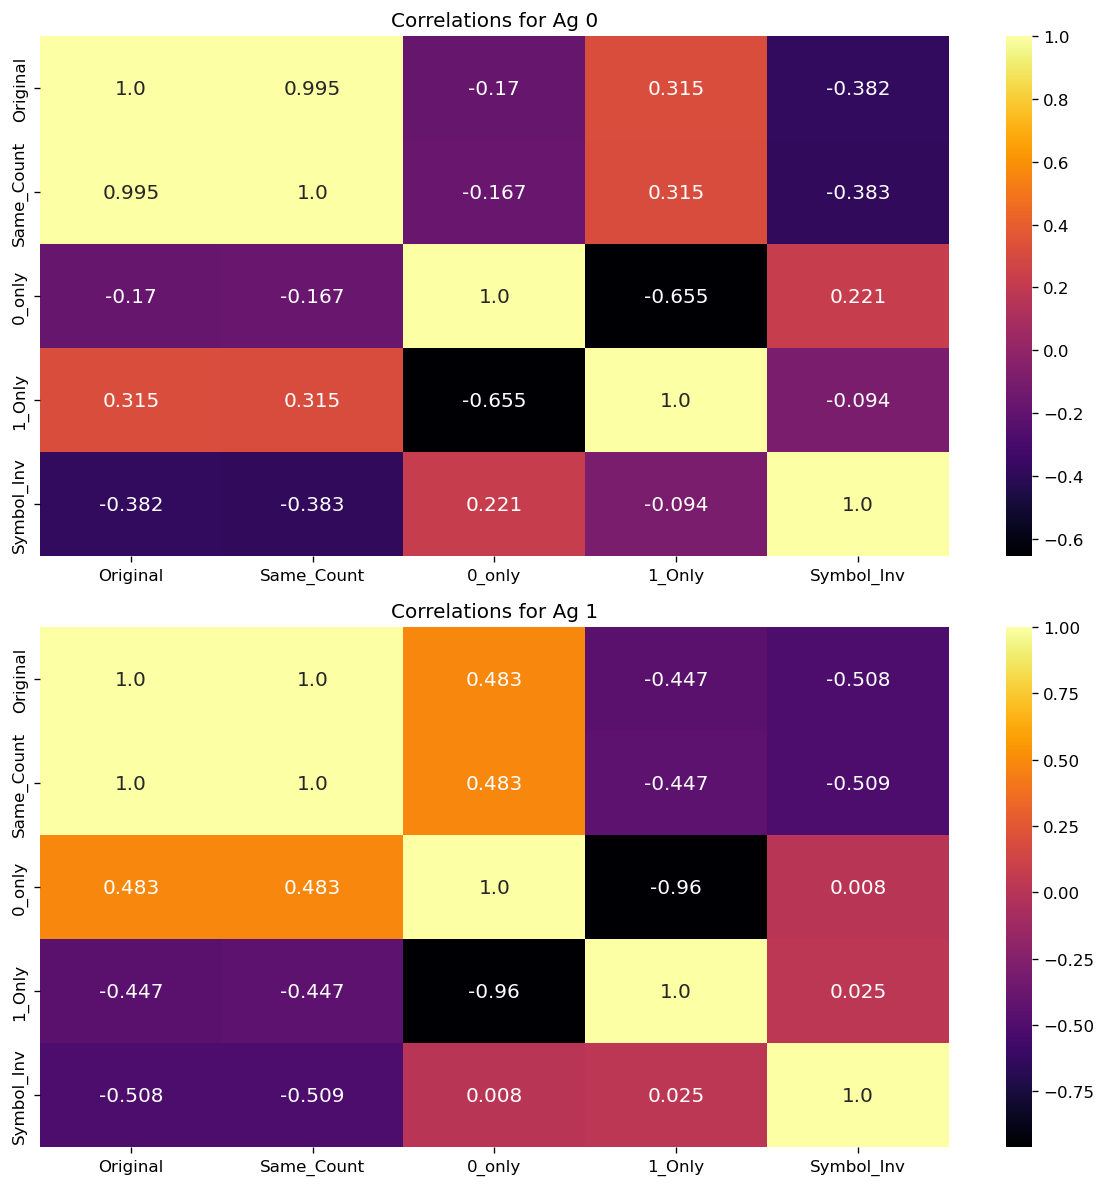

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=120)
scenarios = list(states.keys())

for i, (ax, c) in enumerate(zip(axs, corrs.mean(0))) : 
    ax = sns.heatmap(c, cmap="inferno", annot=c.round(3).astype(str), annot_kws={'fontsize': 12}, fmt='s', ax=ax)
    ax.set_title(f'Correlations for Ag {i}')
    ax.set_xticks(np.arange(len(scenarios))+0.5)
    ax.set_xticklabels(scenarios)
    ax.set_yticks(np.arange(len(scenarios))+0.5)
    ax.set_yticklabels(scenarios)
    
#fig.colorbar(im)

fig.tight_layout()
fig.show()

In [32]:
def get_same_count_data(dataset, idx) : 
    dataset.regenerate = True
    orig_data, orig_label = dataset[idx]
    sym_assigns = [dataset.symbol_assignments[l] for l in orig_label]
    #print(sym_assigns)

    same_count_datas = torch.stack([torch.stack([dataset.__getitem__(idx, symbol_assigns=[s1, s2])[0] for s1 in sym_assigns[0]]) for s2 in sym_assigns[1]])
    same_count_datas_0 = torch.stack([dataset.__getitem__(idx, symbol_assigns=[s1, None])[0] for s1 in sym_assigns[0]], 2)
    same_count_datas_1 = torch.stack([dataset.__getitem__(idx, symbol_assigns=[None, s2])[0] for s2 in sym_assigns[1]], 2)

    dataset.regenerate = False

    return same_count_datas, [same_count_datas_0, same_count_datas_1]

In [ ]:
same_count_datas, same_count_datas_per_ag = get_same_count_data(dataset, idx)

In [ ]:
same_count_datas_per_ag[1].shape

torch.Size([2, 2, 3, 30, 30])

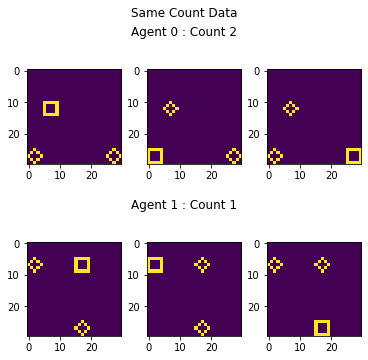

In [44]:

idx = 21
dataset = datasets[0]
data, target =dataset[idx]
same_count_datas, same_count_datas_per_ag = get_same_count_data(dataset, idx)

fig = plt.figure(constrained_layout=True, figsize=(5, 5))
fig.suptitle('Same Count Data')

nrows, ncols = same_count_datas.shape[:2]

subfigs = fig.subfigures(nrows=2, ncols=1)

for ag, subfig in enumerate(subfigs) : 
    data = same_count_datas_per_ag[ag][-1, ag]
    subfig.suptitle(f'Agent {ag} : Count {target[ag]}')
    axs = subfig.subplots(nrows=1, ncols=len(data), sharey=False)
    if len(data) == 1 : axs = np.array([axs])
    for p, ax in enumerate(axs.flatten()) : 
        ax.imshow(data[p])
        #ax.set_title(f'Agent {p}')


In [45]:
from community.funcspec.single_model_loop import compute_all_metrics

In [ ]:
metric_results, all_metric_results = compute_all_metrics